# Compute inundation percent for waterbodies across time

This notebook demonstrates how to load Landsat time series data, identify water pixels using the WOFS algorithm, compute the max extent of water, and calculate the inundation percent compared to max extent for each individual waterbody. This metric can be plotted spatially for different time periods to potentially reveal the impacts of drought across time and space.

**Author**: Robbi Bishop-Taylor

**Date**: 30 October 2018

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
from rasterio.features import shapes
from shapely import geometry
import geopandas as gpd
from rasterstats import zonal_stats
import pandas as pd
from skimage import measure
from skimage import filters
import numpy as np
import matplotlib.pyplot as plt

from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
from utils.data_cube_utilities.ama_notebook_utils import ignore_warnings

dc = datacube.Datacube(app = 'my_app')


## Set up analysis

In [2]:
platform = "LANDSAT_8"
product = "ls8_usgs_sr_scene"

In [3]:
# Area with water
latitude_extents = (-4.65, -4.88)
longitude_extents = (34.7, 34.9)
time_extents = ('2013-01-01', '2018-11-01')

In [4]:
display_map(latitude_extents, longitude_extents)

## Import data

In [5]:
landsat_dataset = dc.load(latitude = latitude_extents,
                          longitude = longitude_extents,
                          platform = platform,
                          product = product,
                          output_crs = 'EPSG:4326', resolution = (-0.0003, 0.0003),
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa'], 
                          time = time_extents,
                          group_by = 'solar_day')
landsat_dataset


<xarray.Dataset>
Dimensions:    (latitude: 767, longitude: 668, time: 105)
Coordinates:
  * time       (time) datetime64[ns] 2013-04-12T07:52:20.766729 ... 2017-12-19T07:50:21.378014
  * latitude   (latitude) float64 -4.65 -4.65 -4.651 ... -4.879 -4.88 -4.88
  * longitude  (longitude) float64 34.7 34.7 34.7 34.7 ... 34.9 34.9 34.9 34.9
Data variables:
    red        (time, latitude, longitude) int16 -9999 -9999 -9999 ... 1164 1162
    green      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 1003 1054
    blue       (time, latitude, longitude) int16 -9999 -9999 -9999 ... 498 541
    nir        (time, latitude, longitude) int16 -9999 -9999 -9999 ... 3079 3145
    swir1      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 2846 2791
    swir2      (time, latitude, longitude) int16 -9999 -9999 -9999 ... 2052 2016
    pixel_qa   (time, latitude, longitude) uint16 1 1 1 1 1 ... 322 322 322 322
Attributes:
    crs:      EPSG:4326

### Mask out clouds

In [6]:
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
cleaned_dataset = landsat_dataset.where(cloud_mask)
cleaned_dataset

<xarray.Dataset>
Dimensions:    (latitude: 767, longitude: 668, time: 105)
Coordinates:
  * time       (time) datetime64[ns] 2013-04-12T07:52:20.766729 ... 2017-12-19T07:50:21.378014
  * latitude   (latitude) float64 -4.65 -4.65 -4.651 ... -4.879 -4.88 -4.88
  * longitude  (longitude) float64 34.7 34.7 34.7 34.7 ... 34.9 34.9 34.9 34.9
Data variables:
    red        (time, latitude, longitude) float64 nan nan ... 1.162e+03
    green      (time, latitude, longitude) float64 nan nan ... 1.054e+03
    blue       (time, latitude, longitude) float64 nan nan nan ... 498.0 541.0
    nir        (time, latitude, longitude) float64 nan nan ... 3.145e+03
    swir1      (time, latitude, longitude) float64 nan nan ... 2.791e+03
    swir2      (time, latitude, longitude) float64 nan nan ... 2.016e+03
    pixel_qa   (time, latitude, longitude) float64 nan nan nan ... 322.0 322.0
Attributes:
    crs:      EPSG:4326

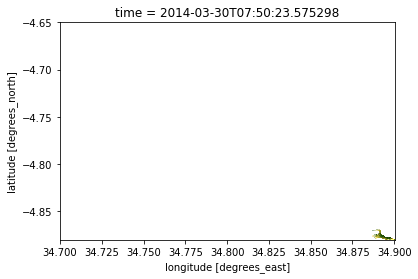

In [7]:
cleaned_dataset[['red', 'green', 'blue']].isel(time=20).to_array().plot.imshow(robust=True)

## Classify water using Water Observations From Space (WOFS) algorithm

In [8]:
wofs_arr = ignore_warnings(wofs_classify, cleaned_dataset).wofs
wofs_arr = wofs_arr.where(wofs_arr != -9999, other=0)
wofs_arr = wofs_arr.where(cloud_mask)
wofs_arr

<xarray.DataArray 'wofs' (time: 105, latitude: 767, longitude: 668)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ...,
        [ 0.,  0., ..., nan, nan],
        [ 0.,  0., ..., nan, nan]],

       ...,

       [[ 0.,  0., ...,  0.,  0.],
        [ 0.,  0., ...,  0.,  0.],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]],

       [[nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.],
        ...,
        [nan, nan, ...,  0.,  0.],
        [nan, nan, ...,  0.,  0.]]])
Coordinates:
  * time       (time) datetime64[ns] 2013-04-12T07:52:20.766729 ... 2017-12-19T07:50:21.378014
  * latitude   (latitude) float64 -4.65 -4.65 -4.651 ... -4.879 -4.88 -4.88
  * longitude  (longitude) float64 34.7 34.7 34.7 34.7 ... 34.9 34.9 34.9 34.9

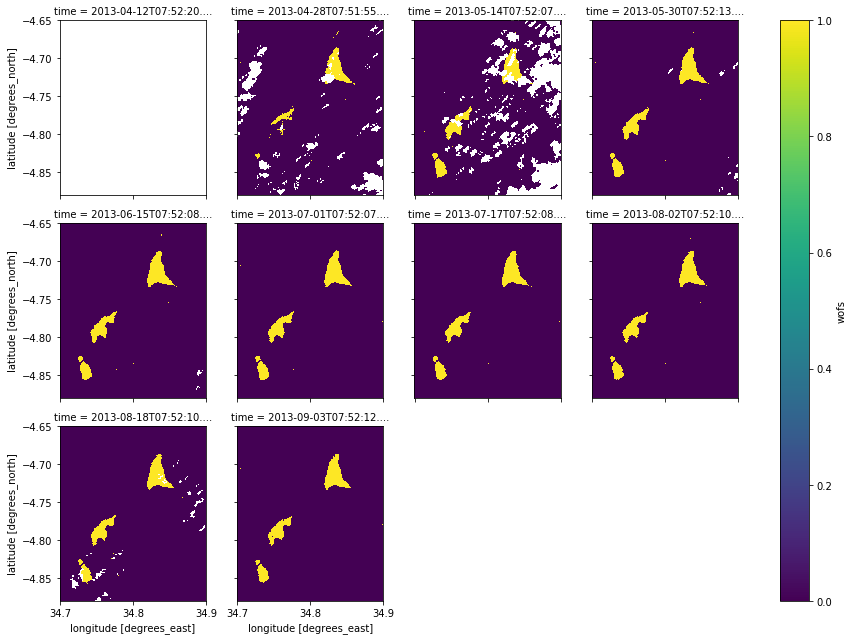

In [9]:
wofs_arr.isel(time=range(0, 10)).plot(col='time', col_wrap=4)

### Compute innundation frequency and max extent layers

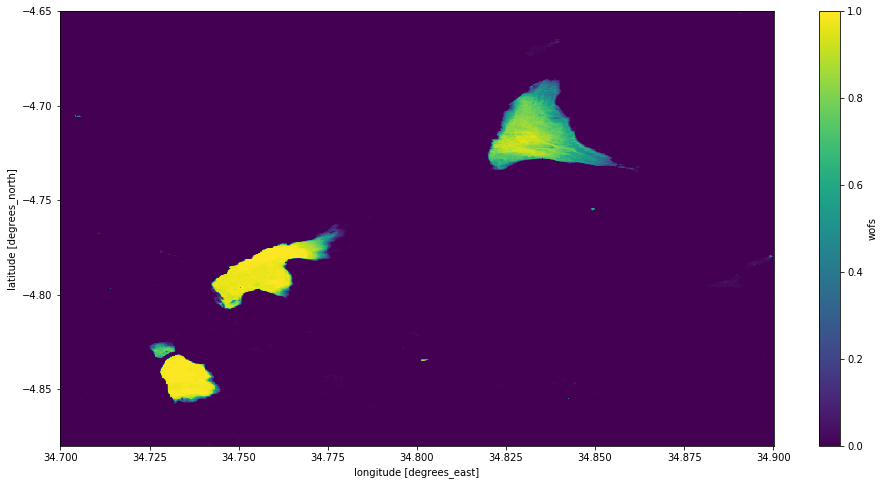

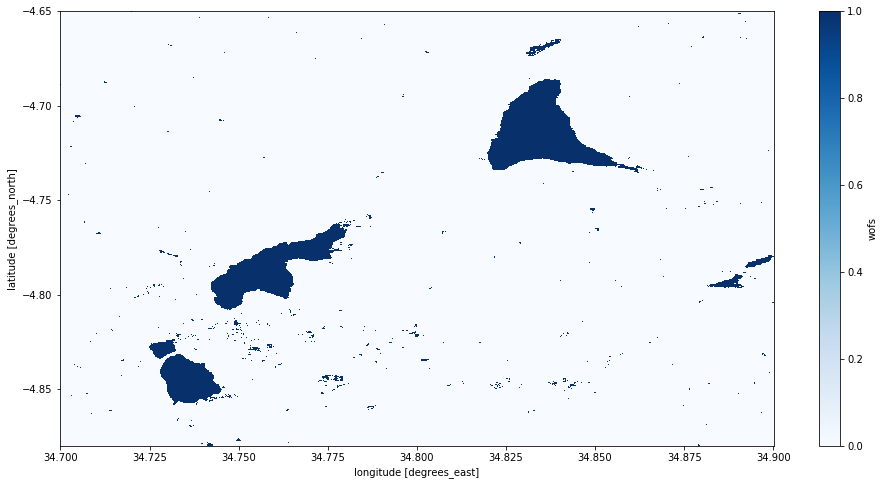

In [10]:
# Compute innundation frequency and max extent
wofs_freq = wofs_arr.mean(dim='time')
wofs_max = wofs_arr.max(dim='time')  

# # Plot frequency
plt.figure(figsize=(16, 8))
wofs_freq.plot()

# Plot max extent
plt.figure(figsize=(16, 8))
wofs_max.plot(cmap='Blues', vmin=0, vmax=1.0)


## Extract unique waterbodies

In [12]:
# Give each discrete waterbody a unique label. Replace NaN with 0 so 
# that these pixels are not given a label
wofs_labelled = measure.label(np.nan_to_num(wofs_max.values, 0))

# Compute area of each unique waterbody. We can then use the unique
# waterbody labels to index into these values and create a spatial
# array where each waterbody has area values. To do this, we first 
# need to add 0 to the beginning of the array, so non-water pixels 
# with a label = 0 are assigned 0 area.
label_areas = [0] + [i.area for i in measure.regionprops(wofs_labelled)] 
wofs_area = np.array(label_areas)[wofs_labelled]

# Polygonise all features with sizes greater than 5
results = [{'properties': {'pixels_total': int(val)}, 
            'geometry': geo} for geo, val in 
           shapes(wofs_area.astype('float32'), transform=cleaned_dataset.geobox.affine, connectivity=8) if val > 20]

# Convert to geopandas dataframe
wofs_gpd = gpd.GeoDataFrame.from_features(results)
wofs_gpd['crs'] = 'EPSG:4326'
wofs_gpd = wofs_gpd.sort_values('pixels_total', ascending=False).reset_index(drop=True)
wofs_gpd['id'] = range(0, len(wofs_gpd))

# Save shapefile to file
wofs_gpd.to_file('GA_outputs/wofs_labelled.shp')

# Plot waterbodies
#fig, ax = plt.subplots(figsize=(16, 8))
#wofs_gpd.plot(edgecolor='black', ax = ax)

In [13]:
wofs_gpd

,geometry,pixels_total,crs,id
0,POLYGON ((34.83629999999999 -4.685999999999999...,9806,EPSG:4326,0
1,"POLYGON ((34.7775 -4.762499999999999, 34.7775 ...",7109,EPSG:4326,1
2,POLYGON ((34.73309999999999 -4.831499999999999...,3337,EPSG:4326,2
3,"POLYGON ((34.7298 -4.8249, 34.7298 -4.8252, 34...",511,EPSG:4326,3
4,POLYGON ((34.88939999999999 -4.789499999999999...,372,EPSG:4326,4
5,"POLYGON ((34.839 -4.664999999999999, 34.839 -4...",292,EPSG:4326,5
6,POLYGON ((34.89899999999999 -4.779299999999999...,236,EPSG:4326,6
7,"POLYGON ((34.7538 -4.8279, 34.7538 -4.82879999...",44,EPSG:4326,7
8,"POLYGON ((34.7277 -4.776899999999999, 34.7277 ...",39,EPSG:4326,8
9,"POLYGON ((34.7493 -4.813499999999999, 34.7493 ...",37,EPSG:4326,9


## Extract innundation % compared to waterbody max extent for each timestep

In [14]:
timestep_stats = []

for time_i in wofs_arr.time:

    i = time_i.values.astype('str')[0:10]
    input_array = wofs_arr.sel(time = i).squeeze('time').values

    # Use Rasterstats to compute zonal statistics for all labelled polygons.
    # Mean = innundation percent, count = number of valid pixels
    results = zonal_stats(vectors='GA_outputs/wofs_labelled.shp', 
                          raster=input_array, 
                          affine=cleaned_dataset.geobox.affine,
                          stats=['mean', 'count'],
                          prefix='{}_'.format(i))

    # Convert to a geopandas dataframe
    results_gpd = pd.DataFrame(results)
    timestep_stats.append(results_gpd)

# Add all timestep data to existing waterbody dataframe
wofs_prop_gpd = pd.concat([wofs_gpd, *timestep_stats], axis=1)

# Convert dataframe to long format for plotting by selecting all 'mean' columns
col_names = wofs_prop_gpd.columns[5::2].values
wofs_prop_melted = wofs_prop_gpd.melt(id_vars=['id', 'pixels_total'],
                                      value_vars=col_names,
                                      value_name='innundation_perc')
wofs_prop_melted['innundation_perc'] = wofs_prop_melted.innundation_perc.astype(float)  

# Extract date from variable column
wofs_prop_melted['date'] = pd.to_datetime(wofs_prop_melted.variable.str.split('_', expand=True)[0])
wofs_prop_melted.sort_values(['date', 'id'])

# Compute number of valid pixels for each waterbody and timestep by selecting all 'count' columns
col_names = wofs_prop_gpd.columns[4::2].values
wofs_valid_melted = wofs_prop_gpd.melt(id_vars=['id', 'pixels_total'],
                                       value_vars=col_names,
                                       value_name='pixels_valid')

# Combine valid pixel column back into dataframe and compute nodata percent
wofs_prop_melted['pixels_valid'] = wofs_valid_melted.pixels_valid
wofs_prop_melted['nodata_perc'] = 1.0 - (wofs_valid_melted.pixels_valid / wofs_valid_melted.pixels_total)

# Select and reorder columns
wofs_prop_melted = wofs_prop_melted[['date', 'id', 'pixels_total', 'pixels_valid', 
                                     'nodata_perc', 'innundation_perc']]

### Plot innundation history for one waterbody across time

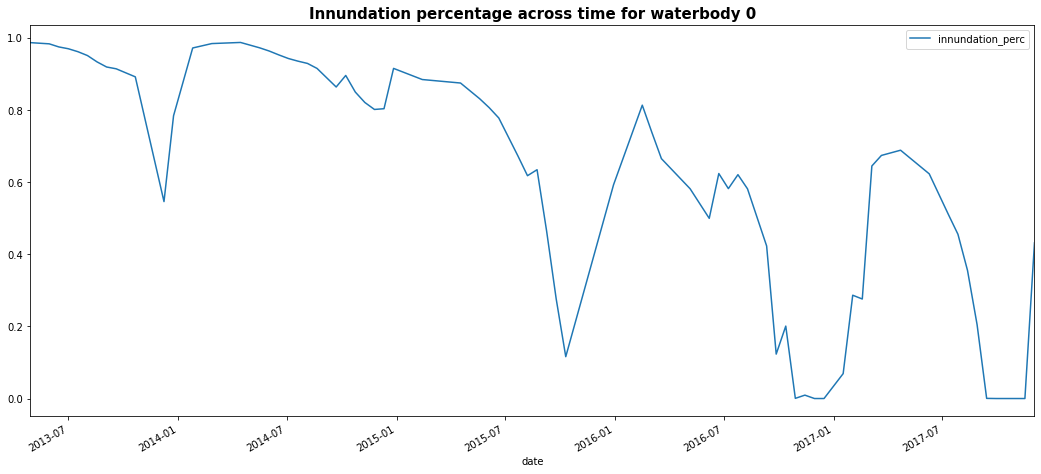

In [18]:
# Plot one waterbody
waterbody_id = 0

# Select data for waterbody and filter out timesteps with less than 50 percent nodata
selected_waterbody = wofs_prop_melted[wofs_prop_melted['id'] == waterbody_id]
selected_waterbody = selected_waterbody[selected_waterbody.nodata_perc < 0.5]

# Plot chart of innundation % across time
fig, ax = plt.subplots(figsize=(18, 8))
selected_waterbody.plot(x='date', y='innundation_perc', ax=ax, color='#1f77b4')
ax.set_title('Innundation percentage across time for waterbody {}'.format(waterbody_id), 
             fontdict={'fontsize': 15, 'fontweight': 'bold'})

# Zoom to selected waterbody from geodataframe for spatial plotting
waterbody_gpd = wofs_prop_gpd[wofs_prop_gpd['id'] == waterbody_id]
(xmin, ymin, xmax, ymax) = waterbody_gpd.geometry.bounds.values[0]
display_map((ymin, ymax), (xmin, xmax))


### Examine dry and wet timesteps for waterbody

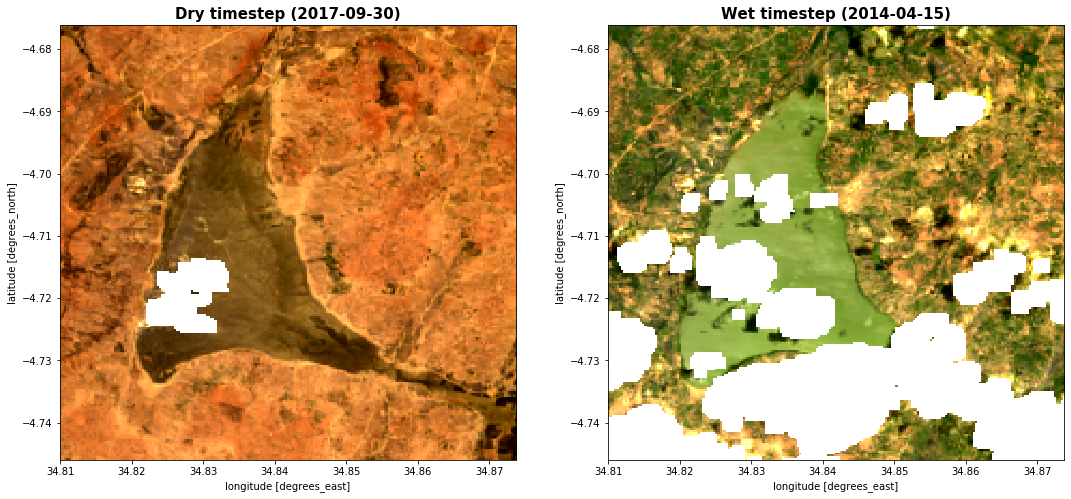

In [19]:
# Identify sample dry or wet timesteps
dry_timestep = str(selected_waterbody.sort_values('innundation_perc').date.iloc[1])[0:10]
wet_timestep = str(selected_waterbody.sort_values('innundation_perc').date.iloc[-1])[0:10]

# Restrict plotting to area around selected waterbody
waterbody_subset = cleaned_dataset[['red', 'green', 'blue']].sel(longitude=slice(xmin - 0.01, xmax + 0.01),
                                                                 latitude=slice(ymax + 0.01, ymin - 0.01))

# Plot dry and wet timestep
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
waterbody_subset.sel(time=dry_timestep).squeeze('time').to_array().plot.imshow(robust=True, ax=axes[0])
waterbody_subset.sel(time=wet_timestep).squeeze('time').to_array().plot.imshow(robust=True, ax=axes[1])
#waterbody_gpd.plot(facecolor="#00000000", edgecolor='black', linewidth=2, ax=axes[0])
#waterbody_gpd.plot(facecolor="#00000000", edgecolor='black', linewidth=2, ax=axes[1])
axes[0].set_title('Dry timestep ({})'.format(dry_timestep), fontdict={'fontsize': 15, 'fontweight': 'bold'});
axes[1].set_title('Wet timestep ({})'.format(wet_timestep), fontdict={'fontsize': 15, 'fontweight': 'bold'});

## Plot average innundation % across recent time (e.g. last 2 months)

In [21]:
# Set the number of most recent months to restrict the analysis
most_recent_months = 2

# Extract only recent observations by selecting dates after cutoff
date_cutoff = wofs_prop_melted.date.iloc[-1] - pd.tseries.offsets.MonthBegin(most_recent_months)
recent_obs = wofs_prop_melted[wofs_prop_melted.date > date_cutoff]

# For each unique waterbody, calculate average innundation % across recent observations
recent_avefilled = recent_obs.groupby(['id']).mean()[['innundation_perc']]

# Combine average innundation % value with geodataframe to allow spatial plotting
recent_avefilled = pd.concat([wofs_gpd, recent_avefilled], axis=1)

# Plot average innundation % for each waterbody
#fig, ax = plt.subplots(figsize=(18, 8))
#recent_avefilled.plot(column='innundation_perc', vmin=0, vmax=1.0, cmap='RdYlBu', 
#                      edgecolor='black', linewidth=0.5, ax=ax, legend=True)
#ax.set_title('Average innundation percent for {} to {} \ncompared to maximum waterbody '
#             'extent between 2013-2017'.format(str(date_cutoff)[0:10], str(wofs_prop_melted.date.iloc[-1])[0:10]),
#            fontdict={'fontsize': 15, 'fontweight': 'bold'});

In [22]:
recent_avefilled

,geometry,pixels_total,crs,id,innundation_perc
0,POLYGON ((34.83629999999999 -4.685999999999999...,9806,EPSG:4326,0,0.320111
1,"POLYGON ((34.7775 -4.762499999999999, 34.7775 ...",7109,EPSG:4326,1,0.646471
2,POLYGON ((34.73309999999999 -4.831499999999999...,3337,EPSG:4326,2,0.810047
3,"POLYGON ((34.7298 -4.8249, 34.7298 -4.8252, 34...",511,EPSG:4326,3,0.053846
4,POLYGON ((34.88939999999999 -4.789499999999999...,372,EPSG:4326,4,0.008065
5,"POLYGON ((34.839 -4.664999999999999, 34.839 -4...",292,EPSG:4326,5,0.166667
6,POLYGON ((34.89899999999999 -4.779299999999999...,236,EPSG:4326,6,0.055085
7,"POLYGON ((34.7538 -4.8279, 34.7538 -4.82879999...",44,EPSG:4326,7,0.000000
8,"POLYGON ((34.7277 -4.776899999999999, 34.7277 ...",39,EPSG:4326,8,0.000000
9,"POLYGON ((34.7493 -4.813499999999999, 34.7493 ...",37,EPSG:4326,9,0.000000
